## BW High Quality

In [2]:

from whale.data_io.data_loader import WhaleDataModule
import torch
from pytorch_lightning import seed_everything
import numpy  as np
from whale.models import LSTM
from matplotlib import pyplot as plt
from whale.utils.spectrogram import show_spectrogram, cal_spectrogram

seed_everything(1234)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

ckpt_path = "//network/projects/aia/whale_call/wandb_log/whale-call-detection/c1pa6bv8/checkpoints/"
best_model_path  = ckpt_path+'epoch=26-step=432.ckpt'
model = LSTM.load_from_checkpoint(best_model_path)
model.eval();
model.to(device);

whale_dm = WhaleDataModule(
    data_dir="/network/projects/aia/whale_call/LABELS/BWC_3CH_HQ", batch_size=1,data_type="spec"
)
whale_dm.setup()

ds_sel = whale_dm.train_ds
dataset_size = len(ds_sel)

/home/mila/g/ge.li/.conda/envs/whale/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Global seed set to 1234


In [3]:
num_samples = 6
idx_rands = np.random.choice(dataset_size, num_samples)

In [4]:
ds_sel[idx_rands[0]]

{'data_index': 815,
 'sig': tensor([[0.6760, 0.5716, 0.2769,  ..., 0.5183, 0.4051, 0.4759]]),
 'spec': tensor([[5.0427e-07, 8.7111e-07, 5.4691e-07,  ..., 8.8978e-10, 1.1547e-09,
          6.1073e-10],
         [2.6557e-07, 5.4003e-07, 5.3747e-07,  ..., 3.9825e-10, 5.1638e-10,
          3.7133e-10],
         [2.9207e-07, 5.8877e-07, 6.2767e-07,  ..., 3.7483e-09, 2.1487e-09,
          3.6729e-10],
         ...,
         [5.9870e-07, 9.9354e-07, 5.4421e-07,  ..., 1.7715e-09, 1.7096e-09,
          9.5769e-10],
         [5.4404e-07, 8.9842e-07, 4.9447e-07,  ..., 1.0223e-09, 1.2810e-09,
          8.1429e-10],
         [4.3621e-07, 7.9414e-07, 5.7363e-07,  ..., 1.7483e-09, 1.5819e-09,
          7.0199e-10]]),
 'target_time': 0.97761494,
 'target_label': 1,
 'meta_data': {'file_path': '/network/projects/aia/whale_call/FILT_10_32/20211002/2021.10.02.CN.PMAQ..CHANNEL.SAC',
  'time_window_start': '2021-10-02 07:13:21.230000',
  'time_window_end': '2021-10-02 07:13:37.230000',
  'time_R_max': '202

### Random Results visualization


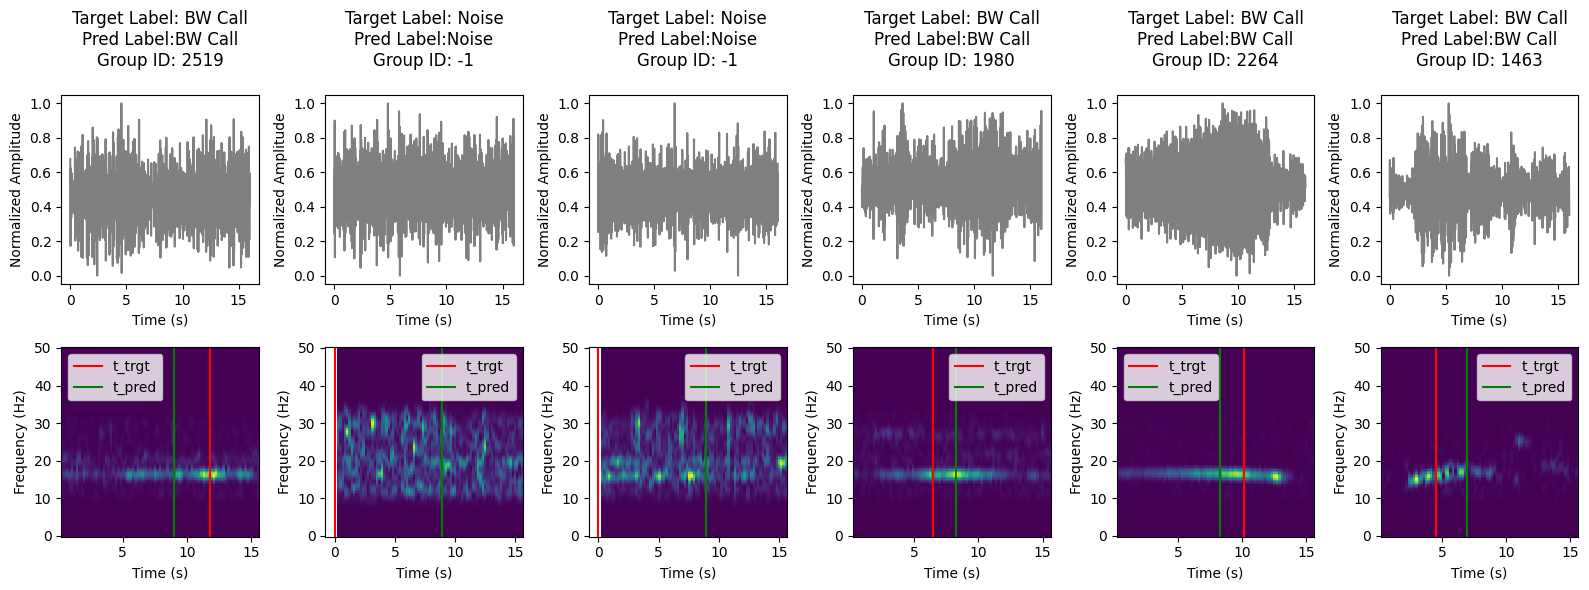

In [8]:
sig_length = 1601
dt = 0.01
t_axis = np.arange(0,sig_length)*dt
label_dict = {0:'Noise',1:'BW Call'}
fig,axs = plt.subplots(2,num_samples,figsize=(16,6))
for i in range(num_samples):
    idx_rand = idx_rands[i]
    data_sel = ds_sel[idx_rand]
    sig = data_sel['sig']
    spectrogram = data_sel['spec']
    target_time = data_sel['target_time']
    target_time = target_time * (ds_sel.target_time_max_val - ds_sel.target_time_min_val) + ds_sel.target_time_min_val
    
    class_logits, reg_out = model(spectrogram.unsqueeze(0).to(device))
    reg_out = reg_out * (ds_sel.target_time_max_val - ds_sel.target_time_min_val) + ds_sel.target_time_min_val
    class_pred = torch.argmax(class_logits,axis=1)
    
    axs[0][i].plot(t_axis,sig[0],color='grey');
    axs[0][i].set_title(f"Target Label: {label_dict[data_sel['target_label']]}\n"+ 
                        f"Pred Label:{label_dict[class_pred.cpu().detach().numpy()[0]]}\n"+
                        f"Group ID: {data_sel['meta_data']['group_id']}\n")
    # add axis labels
    axs[0][i].set_xlabel('Time (s)')
    axs[0][i].set_ylabel('Normalized Amplitude')

    # plot spectrogram and add vertical lines representing target time and predicted time
    ## first get the time and freq bins
    _,freq,time=cal_spectrogram(sig[0],samp_rate=100,per_lap=0.9, wlen=0.5, mult=4)
    # calculate half bin width
    halfbin_time = (time[1] - time[0]) / 2.0
    halfbin_freq = (freq[1] - freq[0]) / 2.0
    # this method is much much faster!
    specgram = np.flipud(spectrogram.T)
    # center bin
    extent = (
        time[0] - halfbin_time,
        time[-1] + halfbin_time,
        freq[0] - halfbin_freq,
        freq[-1] + halfbin_freq,
    )
    axs[1][i].imshow(specgram, interpolation="nearest", extent=extent)

    # show_spectrogram(sig[0],axes=axs[1][i],samp_rate=100,per_lap=0.9, wlen=0.5, mult=4)
    axs[1][i].axvline(x=target_time,color='red')
    axs[1][i].axvline(x=reg_out.cpu().detach().numpy(),color='green')
    axs[1][i].set_xlim([0,time[-1]])
    axs[1][i].axis("tight")
    # ax.grid(False)

    # add axis labels
    axs[1][i].set_xlabel('Time (s)')
    axs[1][i].set_ylabel('Frequency (Hz)')
    # show legend
    axs[1][i].legend(['t_trgt','t_pred'])

plt.tight_layout()
# fig.savefig('prediction_examples_baseline_LSTM_cls_reg.png',dpi=300)
